# Apparel 90-Days-Purchase Prediction


## Project Setup


### Dependencies

In [193]:
import os

from dataclasses import dataclass, field
from datetime import datetime
from functools import wraps
from typing import Any, Callable

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from catboost import CatBoostClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from matplotlib.axes import Axes
from phik.report import plot_correlation_matrix
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import (
    RandomizedSearchCV, StratifiedKFold, train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
)


### Constants

In [194]:
# General Constants
# ==================
RANDOM_STATE = 42
PATH = './datasets'
CSV = {
    'm': 'apparel-messages.csv',
    'p': 'apparel-purchases.csv',
    'y': 'apparel-target_binary.csv',
}
DEV = False


# Preprocessing & EDA
# ===================
INIT_DATE = datetime(year=2022, month=1, day=1)  # reference date: 2022.01.01


# ML Training
# ===========
MINORITY_SIZE = 0.5  # undersampling ratio (0.5 => minority 1:2 majority)
N_ITER = 25
N_ITER_MIN = 5
N_ITER_BS_ADAPT_MULT = 20  # Adaption of N_ITER for each new stability iteration
CV_FOLDS = 5
SEARCH_NUM = 4  # max 4


# Feature Importance
# ==================
FI_LIMIT = 30


### Data Classes


In [195]:
@dataclass
class RawData:
    m: pd.DataFrame | None = None  # apparel-messages.csv
    p: pd.DataFrame | None = None  # apparel-purchases.csv


@dataclass
class DFrame:
    y: pd.DataFrame  # target
    X: pd.DataFrame | None = None  # features
    Xy: pd.DataFrame | None = None  # features & target
    raw: RawData = field(default_factory=RawData)  # origin data  @ overview
    op: RawData = field(default_factory=RawData)  # data operations @ preprocessing
    query: dict[str, Any] = field(default_factory=dict)  # dataframe queries -> views
    view: dict[str, pd.DataFrame] = field(default_factory=dict)  # aggregations etc.
    cache: dict[str, str | list[str | Any] | dict[str, str | Any] | Any] = (
        field(default_factory=dict)  # clipboard like storage
    )
    seed: int = 42  # RANDOM_STATE


@dataclass
class ML:
    models: list[CatBoostClassifier] = field(default_factory=list)
    params: list[dict[str, Any]] = field(default_factory=list)
    roc_auc: list[float] = field(default_factory=list)




### Utils


In [196]:
class Log:
    @staticmethod
    def entries(df_: pd.DataFrame | pd.Series) -> None:
        display(f'{str(len(df_))} entries')


# Aggregation
# ===========
def top(io: pd.Series) -> int | str:
    return io.value_counts().idxmax()

def rare(io: pd.Series) -> int | str:
    return io.value_counts().idxmin()


# Correlation
# ===========
def correlation_mtx(df_: pd.DataFrame, *columns: list[str]) -> None:
    phik_data = pd.get_dummies(
        df_[[*columns]],
        drop_first=True
    )
    phik_matrix = phik_data[phik_data.columns].phik_matrix(
        interval_cols=phik_data.columns
    )
    plot_correlation_matrix(
        phik_matrix.values,
        x_labels=phik_matrix.columns,
        y_labels=phik_matrix.index,
        title=r"Correlation $\phi_K$",
        fontsize_factor=0.8,
        figsize=(12, 9),
        top=50,
    )


In [197]:
@dataclass
class Diagram:
    df: pd.DataFrame
    bins: int = 20
    figsize: tuple[int, int] = (12, 3)
    y_label: str = 'Amount'
    title: tuple[str, str] = ('Histogram', 'Boxplot')
    theme: list[str] = field(
        default_factory=lambda: ['#2b2f75', '#eb4034', '#2b7275', '#752b58']
    )

    def __create_subplots(self, rows: int = 1, cols: int = 2) -> tuple[Axes, ...]:
        _, axes = plt.subplots(rows, cols, figsize=self.figsize)
        return tuple(axes[ax_i] for ax_i in range(cols))

    @staticmethod
    def configure(func: Callable) -> Callable:
        @wraps(func)
        def wrapper(
            self, ax: Axes, title: str, x_label: str, y_label: str, **kw
        ) -> None:
            ax.set_title(title)
            ax.set_xlabel(x_label)
            ax.set_ylabel(y_label)
            func(self, ax=ax, **kw)
            plt.tight_layout()
        return wrapper

    @configure
    def _plot_histogram(self, ax: Axes, column: str, **_) -> None:
        sns.histplot(self.df[column], bins=self.bins, ax=ax)
    
    @configure
    def _plot_boxplot(self, ax: Axes, column: str, **_) -> None:
        sns.boxplot(x=self.df[column], ax=ax)

    def histogram_and_boxplot(self, x_label: str, column: str = '') -> None:
        column = x_label.lower() if not column else column
        ax1, ax2 = self.__create_subplots()
        plot_kwargs = {
            'column': column,
            'x_label': x_label,
            'y_label': self.y_label,
        }
        self._plot_histogram(ax1, title=self.title[0], **plot_kwargs)
        self._plot_boxplot(ax2, title=self.title[1], **plot_kwargs)
        plt.show()
    
    def category_count(
        self, column: str, title: str = '', rotation: int = 0, sort_vc: bool = False
    ) -> None:

        val_counts = self.df[column].sort_values().value_counts(sort=sort_vc)
        plt.figure(figsize=self.figsize)
        val_counts.plot(kind='bar', color=self.theme)
        x_label_title = column.replace('_', ' ').title()
        plot_title = title if title else f'Distribution of {x_label_title}'
        plt.title(plot_title)
        plt.ylabel(self.y_label)
        plt.xlabel(x_label_title)
        plt.xticks(rotation=rotation)
        plt.tight_layout()
        plt.show()


## Target (T)


In [198]:
df = DFrame(y=pd.read_csv(os.path.join(PATH, CSV['y'])), seed=RANDOM_STATE)


The data frames are only loaded if they are required for the next cells.
The reason for this is the size of the CSV files.


### Overview (T)


In [199]:
df.y.info()
df.y.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


### Preprocessing (T)


In [200]:
assert df.y['client_id'].duplicated().sum() == 0  # no action needed


### EDA (T)


'target=1: 1.93%'

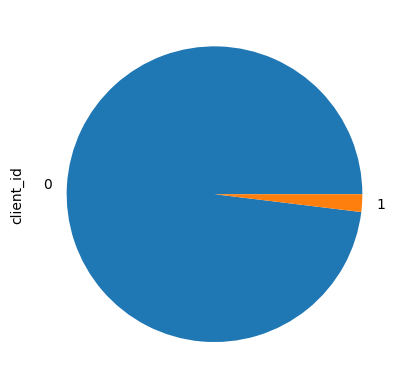

In [201]:
df.y.groupby(by=['target'])['client_id'].count().plot.pie()


'target=1: ' + str(round(df.y['target'].sum() / len(df.y) * 100, 2)) + '%'


## Primary Data Restructuring (Purchase)


### Overview (P)


In [202]:
df.raw.p = pd.read_csv(os.path.join(PATH, CSV['p']), parse_dates=['date'])
df.op.p = df.raw.p.copy()  # memory usage: 9.3+ MB


df.op.p.info()
df.op.p.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


### Preprocessing (P)


#### Duplicates (P)


In [203]:
df.cache['p_duplicates'] = 'sum'
df.query['p_aggr_sum_quantity_price'] = {'quantity': 'sum', 'price': 'sum'}


if df.cache['p_duplicates'] == 'sum':    # .       SUM: quantity=203519, price=241295113
    df.op.p = df.op.p.groupby(list(df.op.p.columns), as_index=False).agg(
        df.query['p_aggr_sum_quantity_price']
    )
else:  # .                                        DROP: quantity=130405, price=163362459
    df.op.p.drop_duplicates(inplace=True)


Log.entries(df.op.p)
df.op.p[['quantity', 'price']].sum().to_frame('total').T


'129188 entries'

,quantity,price
total,203519.0,241295113.0


- As long as the reason for duplicates is not known, their processing is parameterized under `df.cache['p_duplicates'] = 'sum'`.
- The same number of lines is created in both cases of processing.


#### Missing Values (P)


In [204]:
df.cache['p_count_isna_values_for_all_cols']  = 0
for p_column in df.op.p.columns:
    df.cache['p_count_isna_values_for_all_cols']  += int(df.op.p[p_column].isna().sum())


df.cache['p_count_isna_values_for_all_cols'] 


0

##### Category IDs

In [205]:
df.op.p['cat_notna'] = True
df.op.p.loc[df.op.p['category_ids'].str.len() < 10, 'cat_notna'] = False


display(df.op.p.head(3))
df.op.p.groupby(by=['client_id'])['cat_notna'].sum().sort_values().head(3)


,client_id,category_ids,date,message_id,quantity,price,cat_notna
0,1515915625468060902,"['4', '27', '176', '458']",2022-05-27,1515915625468060902-4617-6290657dac196,2,398.0,True
1,1515915625468060902,"['4', '28', '290', '422']",2022-05-27,1515915625468060902-4617-6290657dac196,1,299.0,True
2,1515915625468060902,"['4', '28', '244', '432']",2022-05-27,1515915625468060902-4617-6290657dac196,1,999.0,True


client_id
1515915625560295126    0
1515915625556614907    1
1515915625559850826    1
Name: cat_notna, dtype: int64

In [206]:
df.cache['cat_ids_isna_if_aggr'] = [1515915625560295126]
df.query['p(id=cat_ids_isna_if_aggr)'] = (
    df.op.p['client_id'].isin(df.cache['cat_ids_isna_if_aggr'])
)


display(df.y[df.y['client_id'].isin(df.cache['cat_ids_isna_if_aggr'])])
display(df.op.p[df.query['p(id=cat_ids_isna_if_aggr)'] ])


df.cache['p_cat_ids_mode'] = df.op.p['category_ids'].mode()[0]

df.cache['p_cat_ids_mode']


,client_id,target
28213,1515915625560295126,0


,client_id,category_ids,date,message_id,quantity,price,cat_notna
73782,1515915625560295126,[],2023-06-28,1515915625977590304-13406-649ab07b8d124,1,5199.0,False


"['4', '28', '57', '431']"

In [207]:
df.op.p.loc[df.query['p(id=cat_ids_isna_if_aggr)'], ('category_ids', 'cat_notna')] = (
    df.cache['p_cat_ids_mode'],
    True,
)

df.op.p[df.query['p(id=cat_ids_isna_if_aggr)']]

,client_id,category_ids,date,message_id,quantity,price,cat_notna
73782,1515915625560295126,"['4', '28', '57', '431']",2023-06-28,1515915625977590304-13406-649ab07b8d124,1,5199.0,True


**Summary (Categoriy IDs)**

---

In this process, the handling of missing or incomplete `category_ids` was dealt with by:
- Identifying customers with incomplete `category_ids`,
- Using the most common category (`mode`) as a replacement for missing categories,
- Cleaning the data to ensure that no invalid `category_ids` remain.


In [208]:
df.op.p = df.op.p[df.op.p['cat_notna'] == True]
df.op.p.drop(columns=['cat_notna'], inplace=True)


df.op.p['category_ids'].describe()

count                       125829
unique                         931
top       ['4', '28', '57', '431']
freq                          6192
Name: category_ids, dtype: object

**Explanation (Categoriy IDs)**

---

This step is important to ensure that all entries in the DataFrame contain the necessary information for subsequent analysis or modeling, especially if category information is to be used for prediction.

Removing a single record before aggregation would lead to an inconsistency between the dimensions of the input data (`X`) and the target variable (`y`), as the customer in question is included in the target variable (`target`). Instead of deleting the dataset, the missing value was replaced by imputing the most frequent value (`mode`) to ensure that the database remains complete and consistent.


#### Feature Engineering (P)


##### Date (P)

In [209]:
df.op.p['days'] = (df.op.p['date'] - INIT_DATE).dt.days.astype('int16')
df.op.p['year'] = (df.op.p['date'].dt.year % 2000).astype('int8')
df.op.p.drop(columns=['date'], inplace=True)


df.op.p.head()


,client_id,category_ids,message_id,quantity,price,days,year
0,1515915625468060902,"['4', '27', '176', '458']",1515915625468060902-4617-6290657dac196,2,398.0,146,22
1,1515915625468060902,"['4', '28', '290', '422']",1515915625468060902-4617-6290657dac196,1,299.0,146,22
2,1515915625468060902,"['4', '28', '244', '432']",1515915625468060902-4617-6290657dac196,1,999.0,146,22
3,1515915625468060902,"['4', '27', '1828', '1599']",1515915625468060902-4617-6290657dac196,1,1299.0,146,22
4,1515915625468060902,"['4', '28', '260', '420']",1515915625468060902-4617-6290657dac196,2,3998.0,146,22


##### Message ID (P)


In [210]:
for split_id, msg_col in enumerate(['msg_client', 'bc_id', 'message_hash']):
    df.op.p[msg_col] = df.op.p['message_id'].apply(
        lambda x: str(x).split('-')[split_id]
    )

df.op.p['msg_client'] = df.op.p['msg_client'].astype('int64')
df.op.p['bc_id'] = df.op.p['bc_id'].astype('int32')

df.op.p.drop(columns=['message_hash'], inplace=True)


df.op.p.head()

,client_id,category_ids,message_id,quantity,price,days,year,msg_client,bc_id
0,1515915625468060902,"['4', '27', '176', '458']",1515915625468060902-4617-6290657dac196,2,398.0,146,22,1515915625468060902,4617
1,1515915625468060902,"['4', '28', '290', '422']",1515915625468060902-4617-6290657dac196,1,299.0,146,22,1515915625468060902,4617
2,1515915625468060902,"['4', '28', '244', '432']",1515915625468060902-4617-6290657dac196,1,999.0,146,22,1515915625468060902,4617
3,1515915625468060902,"['4', '27', '1828', '1599']",1515915625468060902-4617-6290657dac196,1,1299.0,146,22,1515915625468060902,4617
4,1515915625468060902,"['4', '28', '260', '420']",1515915625468060902-4617-6290657dac196,2,3998.0,146,22,1515915625468060902,4617


In [211]:
df.op.p['id_delta'] = ((df.op.p['client_id'] - df.op.p['msg_client']).astype('int32'))
# id_delta = client_id - msg_client

df.op.p.drop(columns=['msg_client'], inplace=True)
# msg_client = client_id - id_delta


df.op.p.sample(n=5, random_state=df.seed)


,client_id,category_ids,message_id,quantity,price,days,year,bc_id,id_delta
50012,1515915625500769886,"['5562', '5634', '5693', '636']",1515915625500769886-8072-637f16a626786,1,385.0,328,22,8072,0
79762,1515915625574759700,"['5562', '5630', '5607', '555']",1515915625489581773-14220-65684f7dddc43,2,490.0,699,23,14220,85177927
31525,1515915625489772668,"['4', '28', '213', '436']",1515915625489772668-14631-65c9c26a90fc0,2,798.0,773,24,14631,0
8936,1515915625471222094,"['2', '18', '258', '441']",1515915625471222094-6783-6334027d48de7,1,1750.0,274,22,6783,0
98994,1515915625633786240,"['4', '29', '312', '934']",1515915625633786240-8082-637e277949163,1,1319.0,329,22,8082,0


##### Category IDs (P)


In [212]:
df.op.p['category_ids'] = (
    df.op.p['category_ids'].str.replace('[', '').str.replace(']', '').str.replace(
        "'", ''
    )
)


key_1, key_2 = 'category_ids', 'deepness'
df.op.p[key_2] = df.op.p[key_1].apply(lambda x: len(str(x).split(', '))).astype('int8')
for cat_x in range(1, 6):
    cat_x_key = f'cat_{cat_x}' if cat_x < 4 else f'cat_{cat_x}e'
    cat_x = cat_x if cat_x < 4 else -1 if cat_x == 4 else 0
    df.op.p[cat_x_key] = df.op.p.apply(
        lambda x: str(x[key_1]).split(', ')[cat_x-1]if x[key_2] >= cat_x else None,
        axis=1,
    )
df.op.p.drop(columns=['category_ids'], inplace=True)


df.op.p.sort_values(by=['deepness', 'id_delta']).tail()


,client_id,message_id,quantity,price,days,year,bc_id,id_delta,deepness,cat_1,cat_2,cat_3,cat_4e,cat_5e
124555,1515915625975615205,1515915625491041588-13076-6479c3bb6673c,1,1119.0,518,23,13076,484573617,5,2,17,330,387,467
124556,1515915625975615205,1515915625491041588-13076-6479c3bb6673c,1,1405.0,518,23,13076,484573617,5,2,17,330,387,467
125637,1515915625981117496,1515915625488377606-13372-649150c37fbfe,2,6398.0,535,23,13372,492739890,5,2,17,330,387,467
126310,1515915625983607503,1515915625488777989-13471-64abf28bbff54,1,10.0,555,23,13471,494829514,5,2,17,330,387,467
126311,1515915625983607503,1515915625488777989-13471-64abf28bbff54,1,999.0,555,23,13471,494829514,5,2,17,330,387,467


### Target Shape Aggregation (P)


In [213]:
df.op.p.info()
df.op.p.shape, df.y.shape


<class 'pandas.core.frame.DataFrame'>
Index: 125829 entries, 0 to 129187
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   client_id   125829 non-null  int64  
 1   message_id  125829 non-null  object 
 2   quantity    125829 non-null  int64  
 3   price       125829 non-null  float64
 4   days        125829 non-null  int16  
 5   year        125829 non-null  int8   
 6   bc_id       125829 non-null  int32  
 7   id_delta    125829 non-null  int32  
 8   deepness    125829 non-null  int8   
 9   cat_1       125829 non-null  object 
 10  cat_2       125829 non-null  object 
 11  cat_3       125829 non-null  object 
 12  cat_4e      125829 non-null  object 
 13  cat_5e      125829 non-null  object 
dtypes: float64(1), int16(1), int32(2), int64(2), int8(2), object(6)
memory usage: 11.0+ MB


((125829, 14), (49849, 2))

In [214]:
df.cache['conf_p_aggregation'] = {
    'quantity': ('sum'),
    'price': ('sum'),
    'days': ('min', 'max'),
    'bc_id': ('count', top),
    'message_id': (top, 'nunique'),
    'id_delta': ('nunique'),
    'deepness': ('min'),
    'year': (top),
    'cat_1': (top),
    'cat_2': (top),
    'cat_3': (top),
    'cat_4e': (top),
    'cat_5e': (top),
}
df.view['p_aggregation'] = pd.DataFrame(
    pd.pivot_table(
        df.op.p, 
        values=df.cache['conf_p_aggregation'].keys(),
        index='client_id',
        aggfunc=df.cache['conf_p_aggregation'],
        fill_value=0,
    )
)


df.view['p_aggregation'].head()


bc_id        cat_1 cat_2 cat_3 cat_4e cat_5e days       \
                    count    top   top   top   top    top    top  max  min   
client_id                                                                    
1515915625468060902     5   4617     4    28   176    176    458  146  146   
1515915625468061003     6   9148     4    28   249    249    615  368  368   
1515915625468061099     1   4439     4    28   290    290    424  136  136   
1515915625468061100     1  14623     4    27  1828   1828   5717  770  770   
1515915625468061170     7  11208     4    28   260    260    420  532  449   

                    deepness id_delta message_id  \
                         min  nunique    nunique   
client_id                                          
1515915625468060902        4        1          1   
1515915625468061003        4        1          1   
1515915625468061099        4        1          1   
1515915625468061100        4        1          1   
1515915625468061170        4        1          3   

                                                                price  \
                                                         top      sum   
client_id                                                               
1515915625468060902   1515915625468060902-4617-6290657dac196   6993.0   
1515915625468061003   1515915625468061003-9148-63b54b04855a4  16235.0   
1515915625468061099   1515915625468061099-4439-62834141aa538    299.0   
1515915625468061100  1515915625468061100-14623-65c5c55eeb9e0   2098.0   
1515915625468061170  1515915625468061170-11208-6423f082d2fcb  33587.0   

                    quantity year  
                         sum  top  
client_id                          
1515915625468060902        7   22  
1515915625468061003        7   23  
1515915625468061099        1   22  
1515915625468061100        2   24  
1515915625468061170       17   23

In [215]:
df.view['p_aggregation'].columns = [
    '{}_{}'.format(col[0], col[1]) for col in df.view['p_aggregation'].columns
]
df.view['p_aggregation'] = df.view['p_aggregation'].reset_index()

df.view['p_aggregation'].head(3)


,client_id,bc_id_count,bc_id_top,cat_1_top,cat_2_top,cat_3_top,cat_4e_top,cat_5e_top,days_max,days_min,deepness_min,id_delta_nunique,message_id_nunique,message_id_top,price_sum,quantity_sum,year_top
0,1515915625468060902,5,4617,4,28,176,176,458,146,146,4,1,1,1515915625468060902-4617-6290657dac196,6993.0,7,22
1,1515915625468061003,6,9148,4,28,249,249,615,368,368,4,1,1,1515915625468061003-9148-63b54b04855a4,16235.0,7,23
2,1515915625468061099,1,4439,4,28,290,290,424,136,136,4,1,1,1515915625468061099-4439-62834141aa538,299.0,1,22


### EDA (P)


In [216]:
diagram = Diagram(df=df.view['p_aggregation'])

#### Nummeric (P)

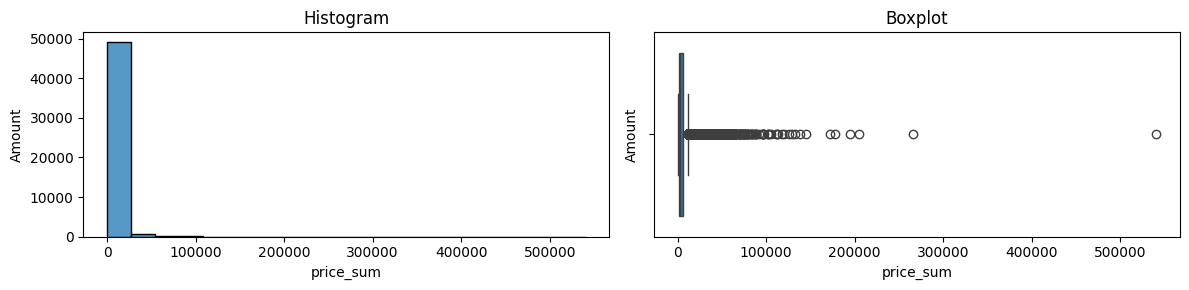

In [217]:
diagram.histogram_and_boxplot(x_label='price_sum')


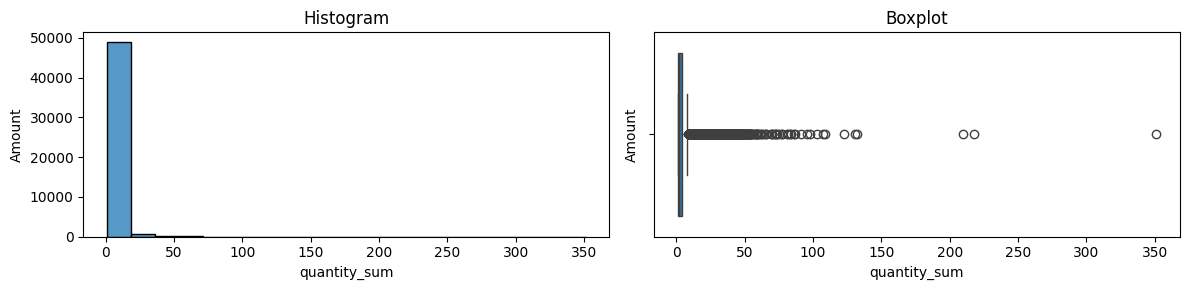

In [218]:
diagram.histogram_and_boxplot(x_label='quantity_sum')


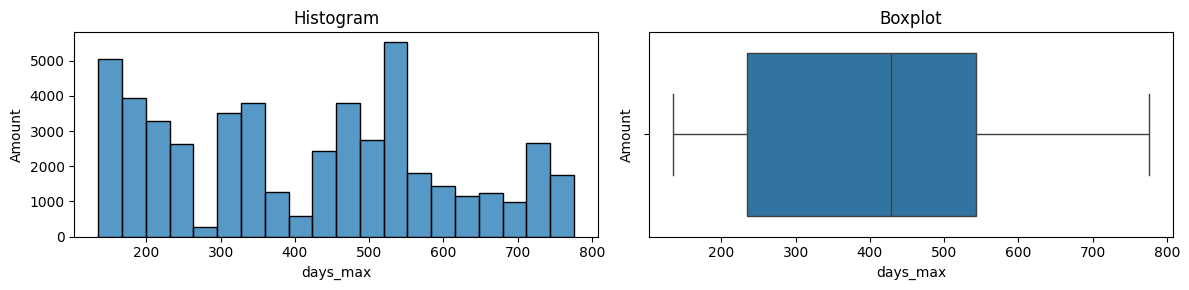

In [219]:
diagram.histogram_and_boxplot(x_label='days_max')


#### Categories (P)


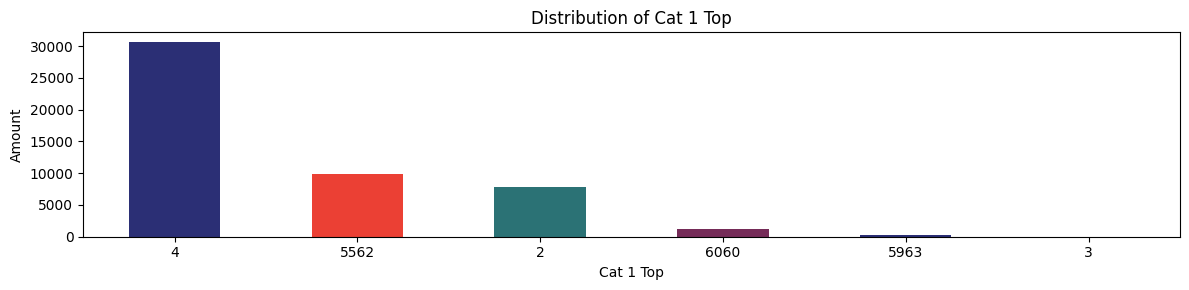

In [220]:
diagram.category_count('cat_1_top', sort_vc=True)


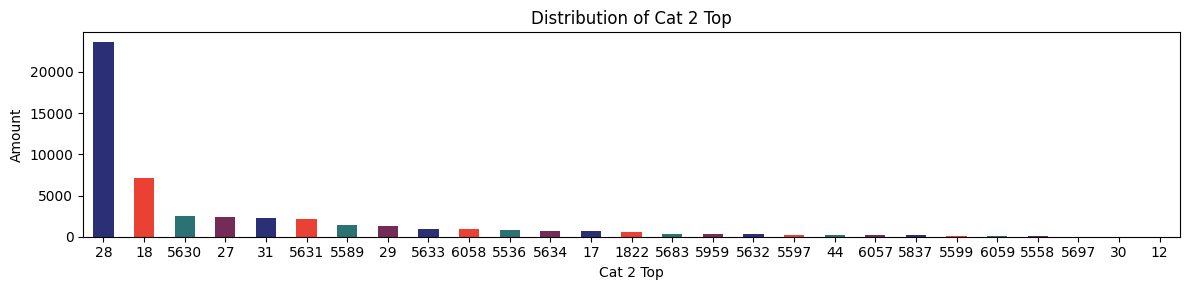

In [221]:
diagram.category_count('cat_2_top', sort_vc=True)


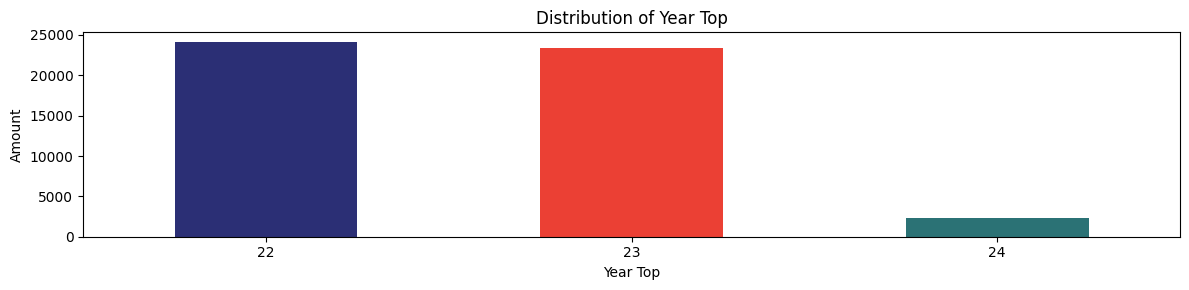

In [222]:
diagram.category_count('year_top', sort_vc=True)


## Secondary Data Restructuturing (Messages)


### Overview (M)


In [223]:
df.raw.m = pd.read_csv(os.path.join(PATH, CSV['m']), parse_dates=['date', 'created_at'])


df.raw.m.info()
df.raw.m.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [224]:
df.raw.m[['event', 'channel']].describe()


,event,channel
count,12739798,12739798
unique,11,2
top,send,mobile_push
freq,9058196,7512156


In [225]:
df.raw.m[['date', 'created_at']].describe()


,date,created_at
count,12739798,12739798
mean,2023-06-05 02:46:08.357990400,2023-06-05 13:58:11.168689408
min,2022-05-19 00:00:00,2022-05-19 00:14:20
25%,2022-12-19 00:00:00,2022-12-19 12:46:30
50%,2023-07-20 00:00:00,2023-07-20 17:21:54
75%,2023-11-21 00:00:00,2023-11-21 18:13:05
max,2024-02-15 00:00:00,2024-02-15 23:58:40


In [226]:
df.raw.m[['client_id', 'bulk_campaign_id']].astype(str).describe()


,client_id,bulk_campaign_id
count,12739798,12739798
unique,53329,2709
top,1515915625516327994,14272
freq,3100,104479


### Preprocessing (M)


In [227]:
df.cache['large_dataframes_if_not_used'] = 'delete'
df.op.m = df.raw.m.copy()

if df.cache['large_dataframes_if_not_used'] == 'delete':
    df.raw.m = None


Log.entries(df.op.m)

'12739798 entries'

#### Duplicates (M)


In [228]:
df.cache['m_duplicates_number'] = int(df.op.m.duplicated().sum())
df.op.m.drop_duplicates(inplace=True)


df.cache['m_duplicates_number'], int(df.op.m.duplicated().sum())


(48610, 0)

In [229]:
df.op.m['message_id'].describe()


count                                   12691188
unique                                   9061667
top       1515915625489095763-6251-6311b13a4cf78
freq                                        1427
Name: message_id, dtype: object

### Target Shape Aggregation (M)


In [230]:
df.op.m.info()
df.op.m.head(3)


<class 'pandas.core.frame.DataFrame'>
Index: 12691188 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 774.6+ MB


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49


In [231]:
df.op.m['days'] = (df.op.m['date'] - INIT_DATE).dt.days.astype('int16')


df.op.m.head(3)


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,days
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20,138
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34,138
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49,138


In [232]:
df.cache['conf_m_aggregation'] = {
    'bulk_campaign_id': ('count', top),
    'message_id': ('nunique', top),
    'event': (rare, top),
    'days': ('min', top, 'max'),
    'date': ('max'),
}
df.view['m_aggregation'] = pd.DataFrame(
    pd.pivot_table(
        df.op.m, 
        values=df.cache['conf_m_aggregation'].keys(),
        index='client_id',
        columns=['channel'],
        aggfunc=df.cache['conf_m_aggregation'],
        fill_value=None,
    )
)


df.view['m_aggregation'].head()


bulk_campaign_id                                   \
                               count                  top               
channel                        email mobile_push    email mobile_push   
client_id                                                               
1515915625468060902            177.0         NaN   4617.0         NaN   
1515915625468061003            165.0         NaN  12566.0         NaN   
1515915625468061099            182.0        94.0   9945.0      7818.0   
1515915625468061100              NaN       428.0      NaN     14280.0   
1515915625468061170            202.0        91.0  11144.0     14024.0   

                          date               days                     \
                           max                max                min   
channel                  email mobile_push  email mobile_push  email   
client_id                                                              
1515915625468060902 2024-01-19         NaT  748.0         NaN  138.0   
1515915625468061003 2024-02-13         NaT  773.0         NaN  139.0   
1515915625468061099 2024-02-13  2022-12-26  773.0       359.0  138.0   
1515915625468061100        NaT  2024-02-15    NaN       775.0    NaN   
1515915625468061170 2024-02-15  2024-02-15  775.0       775.0  144.0   

                                                          event               \
                                   top                     rare                
channel             mobile_push  email mobile_push        email  mobile_push   
client_id                                                                      
1515915625468060902         NaN  146.0         NaN  unsubscribe          NaN   
1515915625468061003         NaN  368.0         NaN     purchase          NaN   
1515915625468061099       173.0  604.0       230.0        click  hard_bounce   
1515915625468061100       138.0    NaN       502.0          NaN  hard_bounce   
1515915625468061170       667.0  452.0       683.0     purchase         open   

                                      message_id              \
                      top                nunique               
channel             email mobile_push      email mobile_push   
client_id                                                      
1515915625468060902  send         NaN      127.0         NaN   
1515915625468061003  send         NaN      154.0         NaN   
1515915625468061099  send        send      157.0        58.0   
1515915625468061100   NaN        send        NaN       268.0   
1515915625468061170  send        send      164.0        79.0   

                                                              \
                                                         top   
channel                                                email   
client_id                                                      
1515915625468060902   1515915625468060902-4617-6290657dac196   
1515915625468061003  1515915625468061003-12566-646330138e845   
1515915625468061099   1515915625468061099-9945-63e34e9af27f3   
1515915625468061100                                      NaN   
1515915625468061170  1515915625468061170-11144-641ad2cda77a2   

                                                              
                                                              
channel                                          mobile_push  
client_id                                                     
1515915625468060902                                      NaN  
1515915625468061003                                      NaN  
1515915625468061099   1515915625468061099-7818-636f6eb22f7ba  
1515915625468061100  1515915625468061100-14623-65c5c55eeb9e0  
1515915625468061170  1515915625468061170-14024-653f86710149c

In [233]:
df.view['m_aggregation'].columns = [
    '{}_{}_{}'.format(col[0], col[1], col[2]) for col in df.view['m_aggregation'].columns
]
df.view['m_aggregation'] = df.view['m_aggregation'].reset_index()


df.view['m_aggregation'].head(3).T

,0,1,2
client_id,1515915625468060902,1515915625468061003,1515915625468061099
bulk_campaign_id_count_email,177.0,165.0,182.0
bulk_campaign_id_count_mobile_push,NaN,NaN,94.0
bulk_campaign_id_top_email,4617.0,12566.0,9945.0
bulk_campaign_id_top_mobile_push,NaN,NaN,7818.0
date_max_email,2024-01-19 00:00:00,2024-02-13 00:00:00,2024-02-13 00:00:00
date_max_mobile_push,NaT,NaT,2022-12-26 00:00:00
days_max_email,748.0,773.0,773.0
days_max_mobile_push,NaN,NaN,359.0
days_min_email,138.0,139.0,138.0


### Feature Engineering (M)


In [234]:
df.view['m_aggregation']['message_id_top'] = df.view['m_aggregation'].apply(
    lambda x: x['message_id_top_email'] if x['message_id_top_email'] else x['message_id_top_mobile_push'],
    axis=1
)


df.view['m_aggregation'].head(3).T


,0,1,2
client_id,1515915625468060902,1515915625468061003,1515915625468061099
bulk_campaign_id_count_email,177.0,165.0,182.0
bulk_campaign_id_count_mobile_push,NaN,NaN,94.0
bulk_campaign_id_top_email,4617.0,12566.0,9945.0
bulk_campaign_id_top_mobile_push,NaN,NaN,7818.0
date_max_email,2024-01-19 00:00:00,2024-02-13 00:00:00,2024-02-13 00:00:00
date_max_mobile_push,NaT,NaT,2022-12-26 00:00:00
days_max_email,748.0,773.0,773.0
days_max_mobile_push,NaN,NaN,359.0
days_min_email,138.0,139.0,138.0


### EDA (M)


In [235]:
eda_m = Diagram(df=df.view['m_aggregation'])


#### Nummeric (M)


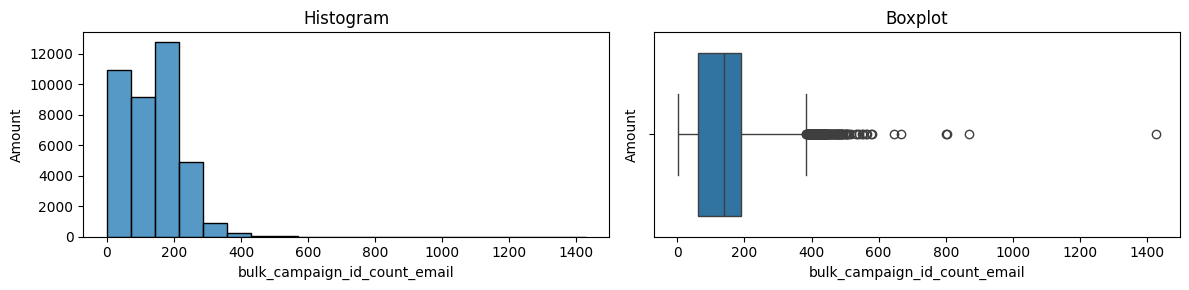

In [236]:
eda_m.histogram_and_boxplot(x_label='bulk_campaign_id_count_email')


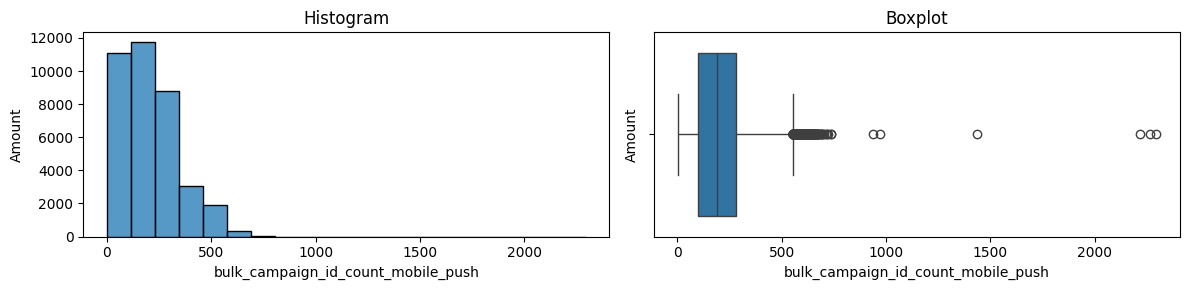

In [237]:
eda_m.histogram_and_boxplot(x_label='bulk_campaign_id_count_mobile_push')


#### Category (M)


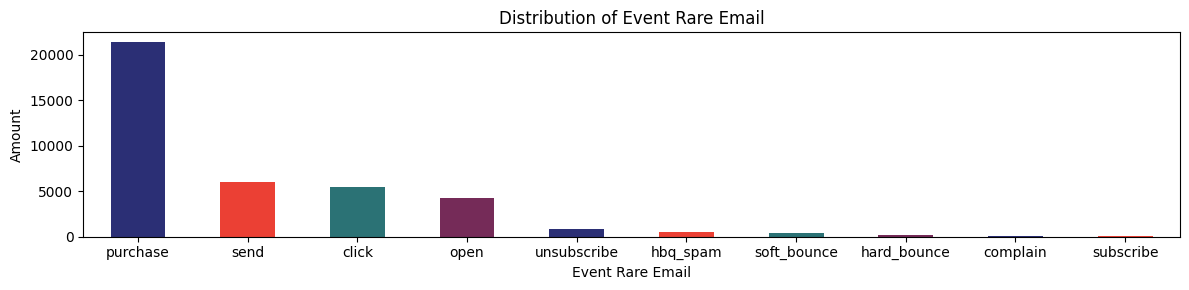

In [238]:
eda_m.category_count('event_rare_email', sort_vc=True)

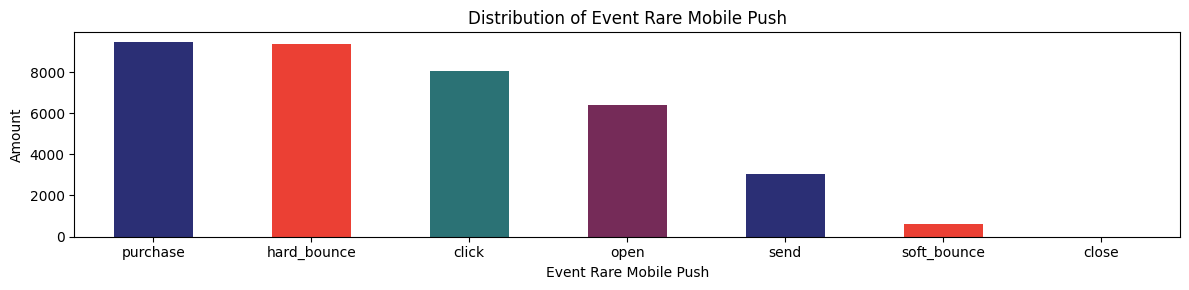

In [239]:
eda_m.category_count('event_rare_mobile_push', sort_vc=True)


## Data Merging


### Purchases (Merging)


In [240]:
df.Xy = df.y.merge(df.view['p_aggregation'], on='client_id')

sorted(df.Xy.columns.to_list())

['bc_id_count',
 'bc_id_top',
 'cat_1_top',
 'cat_2_top',
 'cat_3_top',
 'cat_4e_top',
 'cat_5e_top',
 'client_id',
 'days_max',
 'days_min',
 'deepness_min',
 'id_delta_nunique',
 'message_id_nunique',
 'message_id_top',
 'price_sum',
 'quantity_sum',
 'target',
 'year_top']

### Messages (Merging)


In [241]:
df.Xy = df.Xy.merge(
    df.view['m_aggregation'].drop(columns=['client_id']),
    on='message_id_top',
)
assert df.Xy['client_id'].duplicated().sum() == 0


sorted(df.view['m_aggregation'].drop(columns=['client_id']).columns.to_list())


['bulk_campaign_id_count_email',
 'bulk_campaign_id_count_mobile_push',
 'bulk_campaign_id_top_email',
 'bulk_campaign_id_top_mobile_push',
 'date_max_email',
 'date_max_mobile_push',
 'days_max_email',
 'days_max_mobile_push',
 'days_min_email',
 'days_min_mobile_push',
 'days_top_email',
 'days_top_mobile_push',
 'event_rare_email',
 'event_rare_mobile_push',
 'event_top_email',
 'event_top_mobile_push',
 'message_id_nunique_email',
 'message_id_nunique_mobile_push',
 'message_id_top',
 'message_id_top_email',
 'message_id_top_mobile_push']

## Overview


In [242]:
df.Xy.head(3).T

,0,1,2
client_id,1515915625468060902,1515915625468061877,1515915625468061975
target,0,0,0
bc_id_count,5,1,1
bc_id_top,4617,5922,5662
cat_1_top,4,5562,4
cat_2_top,28,5630,5837
cat_3_top,176,5699,5838
cat_4e_top,176,5699,5838
cat_5e_top,458,1829,1848
days_max,146,230,207


In [243]:
df.Xy.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23100 entries, 0 to 23099
Data columns (total 38 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   client_id                           23100 non-null  int64         
 1   target                              23100 non-null  int64         
 2   bc_id_count                         23100 non-null  int64         
 3   bc_id_top                           23100 non-null  int32         
 4   cat_1_top                           23100 non-null  object        
 5   cat_2_top                           23100 non-null  object        
 6   cat_3_top                           23100 non-null  object        
 7   cat_4e_top                          23100 non-null  object        
 8   cat_5e_top                          23100 non-null  object        
 9   days_max                            23100 non-null  int16         
 10  days_min              

## Preprocessing II


In [244]:
df.Xy['bc_id_cat'] = df.Xy['bc_id_top'].astype(str)
df.Xy['year_top'] = df.Xy['year_top'].astype(str)


In [245]:
df.Xy['bulk_campaign_id_top_email'] = (
    df.Xy['bulk_campaign_id_top_email'].fillna(0).astype(int).astype(str)
)
df.Xy['bulk_campaign_id_top_mobile_push'] = (
    df.Xy['bulk_campaign_id_top_mobile_push'].fillna(0).astype(int).astype(str)
)


In [246]:
df.cache['columns_with_rare_classes'] = ['cat_3_top', 'cat_4e_top', 'cat_5e_top']
df.cache['cat_threshold'] = 0.005


for cat_feature in df.cache['columns_with_rare_classes']:
    category_counts: pd.Series = df.Xy[cat_feature].value_counts(normalize=True)
    rare_categories = category_counts[category_counts < df.cache['cat_threshold']].index
    df.Xy[cat_feature] = df.Xy[cat_feature].apply(
        lambda x: 'other' if x in rare_categories else x
    )


df.Xy[df.cache['columns_with_rare_classes']].nunique().to_frame('number_of_classes').T


,cat_3_top,cat_4e_top,cat_5e_top
number_of_classes,44,45,47


## Feature Engineering II


In [247]:
df.Xy['days_max_until_email_max'] = df.Xy['days_max_email'] - df.Xy['days_max']
df.Xy['days_max_until_push_max'] = df.Xy['days_max_mobile_push'] - df.Xy['days_max']
df.Xy['days_max_mail_min'] = df.Xy['days_min_email'] - df.Xy['days_max']
df.Xy['days_max_until_push_min'] = df.Xy['days_min_mobile_push'] - df.Xy['days_max']

## EDA II


In [248]:
eda_2 = Diagram(df.Xy)


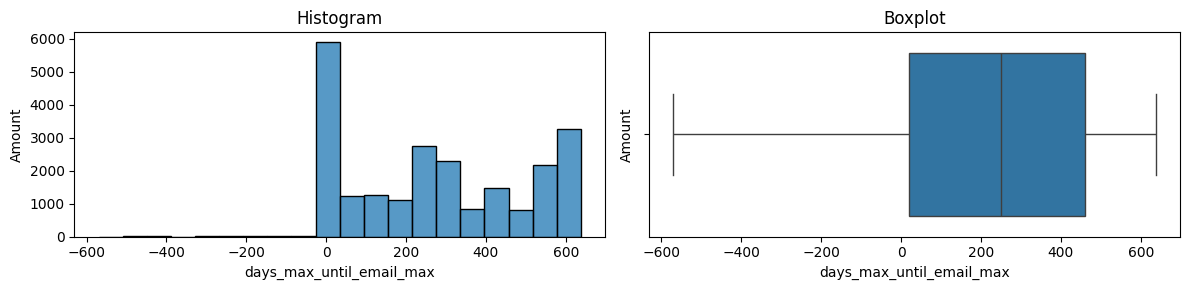

In [249]:
eda_2.histogram_and_boxplot(x_label='days_max_until_email_max')


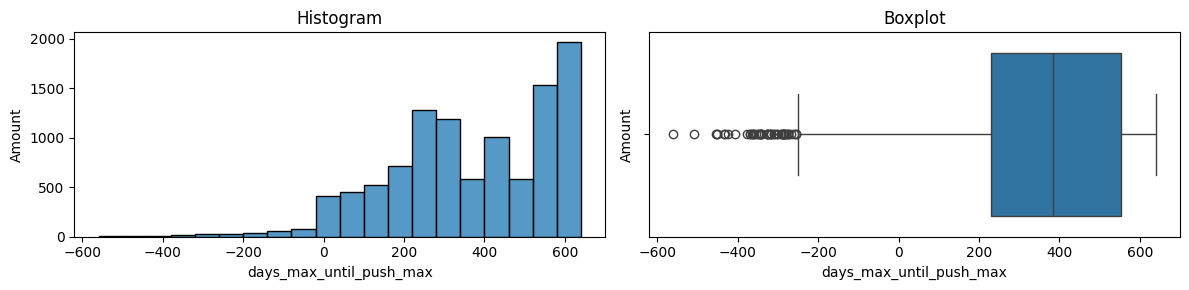

In [250]:
eda_2.histogram_and_boxplot(x_label='days_max_until_push_max')


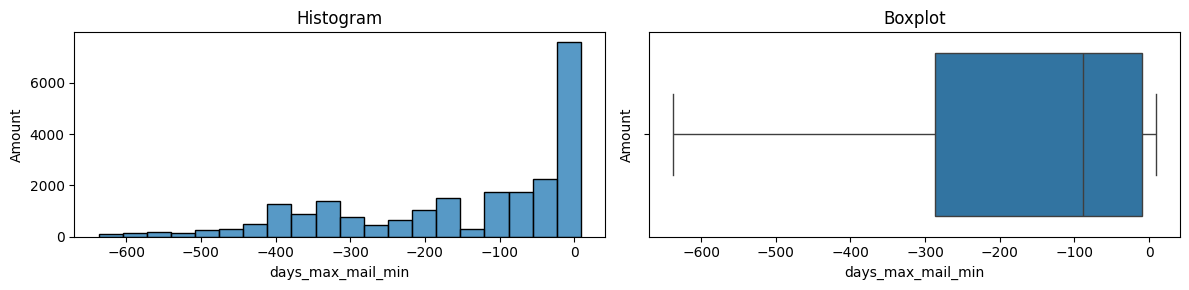

In [251]:
eda_2.histogram_and_boxplot(x_label='days_max_mail_min')


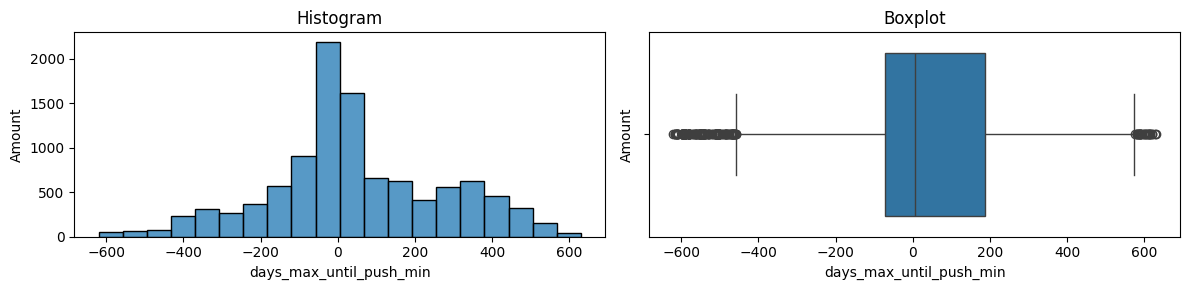

In [252]:
eda_2.histogram_and_boxplot(x_label='days_max_until_push_min')


## Correlation


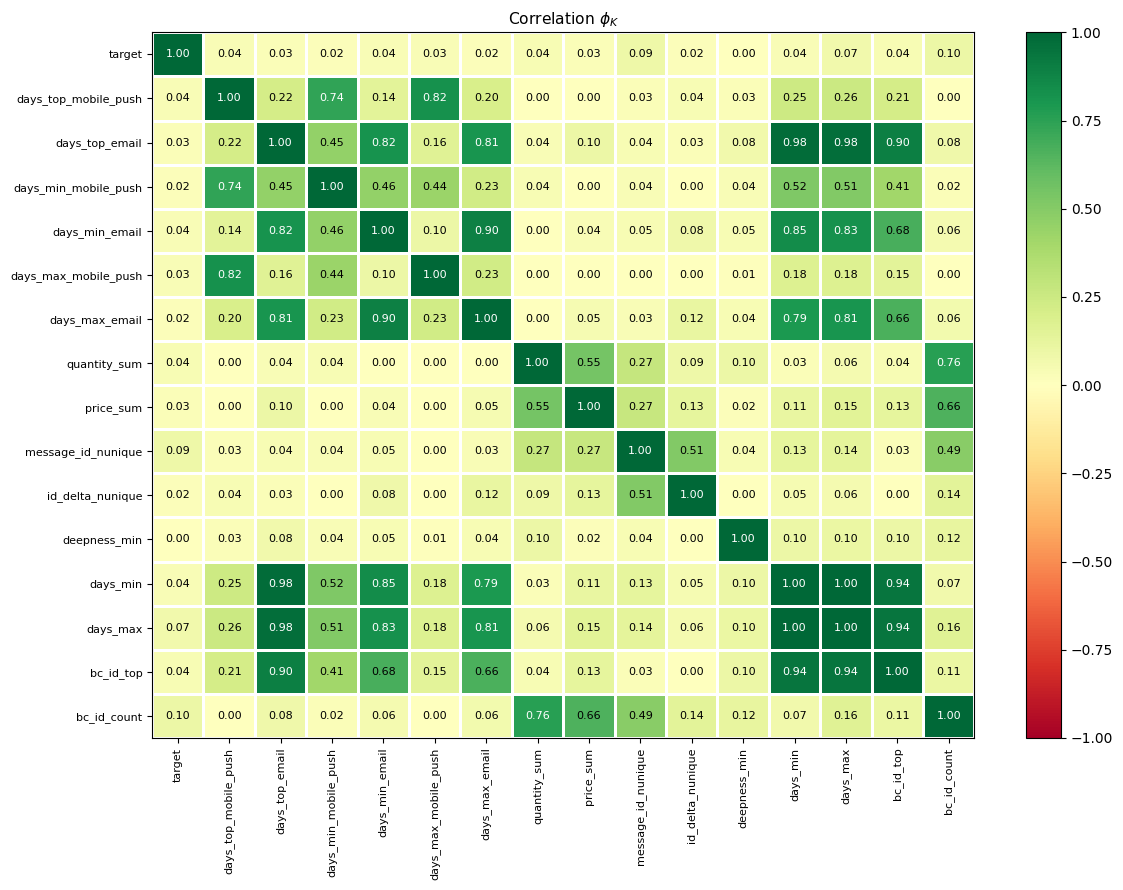

In [253]:
correlation_mtx(
    df.Xy,
    'bc_id_count',
    'bc_id_top',
    'days_max',
    'days_min',
    'deepness_min',
    'id_delta_nunique',
    'message_id_nunique',
    'price_sum',
    'quantity_sum',
    'days_max_email',
    'days_max_mobile_push',
    'days_min_email',
    'days_min_mobile_push',
    'days_top_email',
    'days_top_mobile_push',
    'target',
)


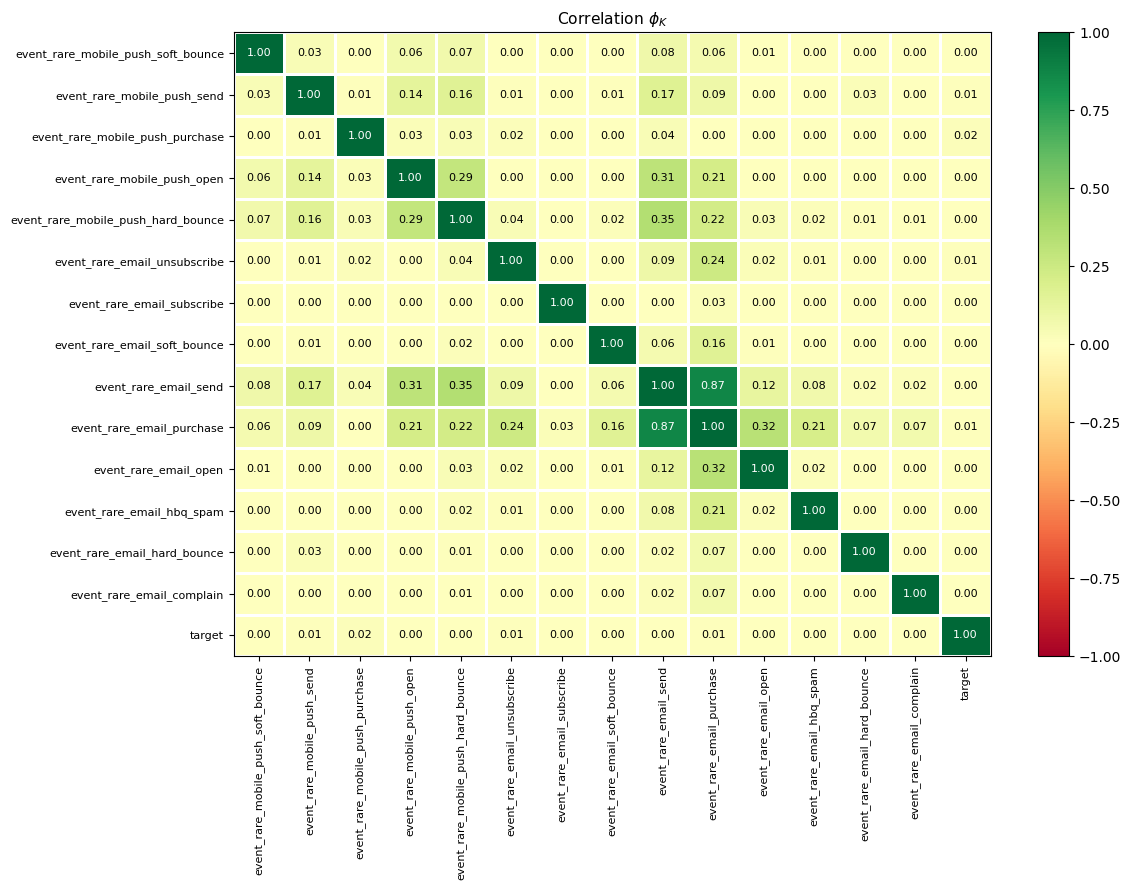

In [254]:
correlation_mtx(df.Xy, 'event_rare_email', 'event_rare_mobile_push', 'target')


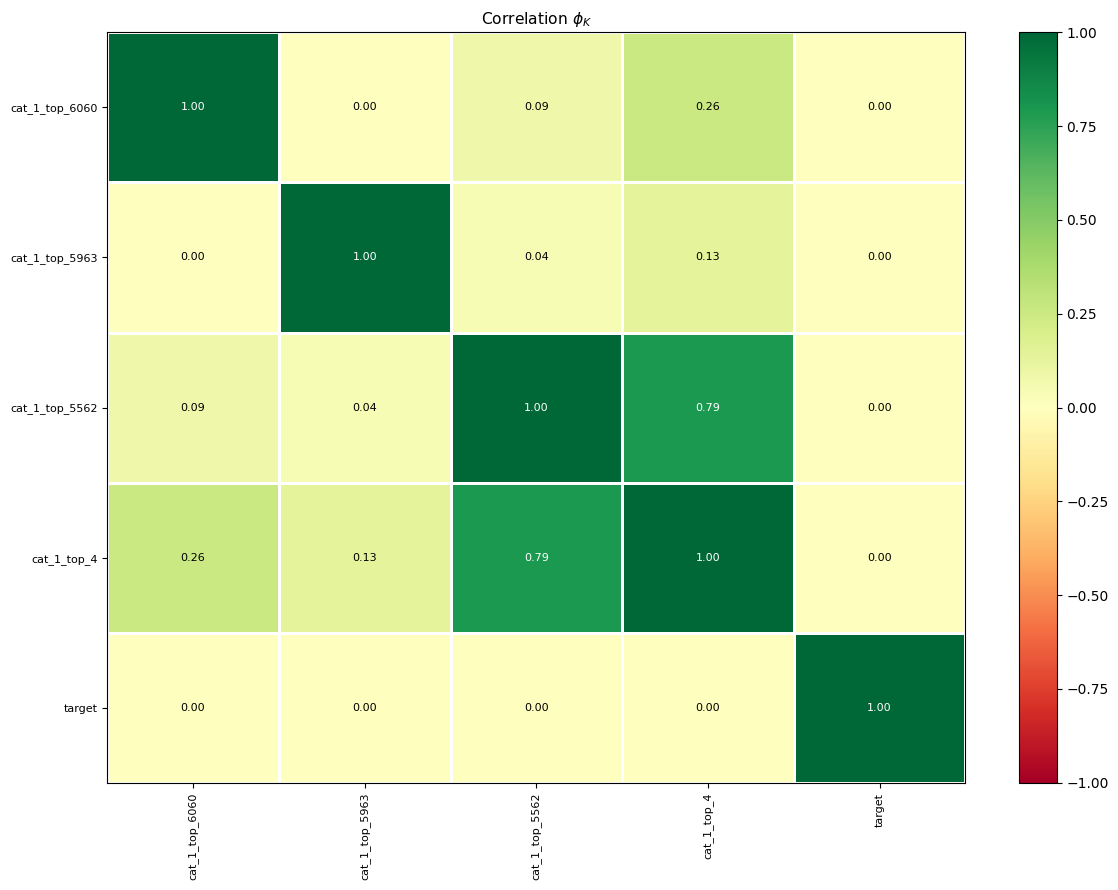

In [255]:
correlation_mtx(df.Xy, 'cat_1_top', 'target')


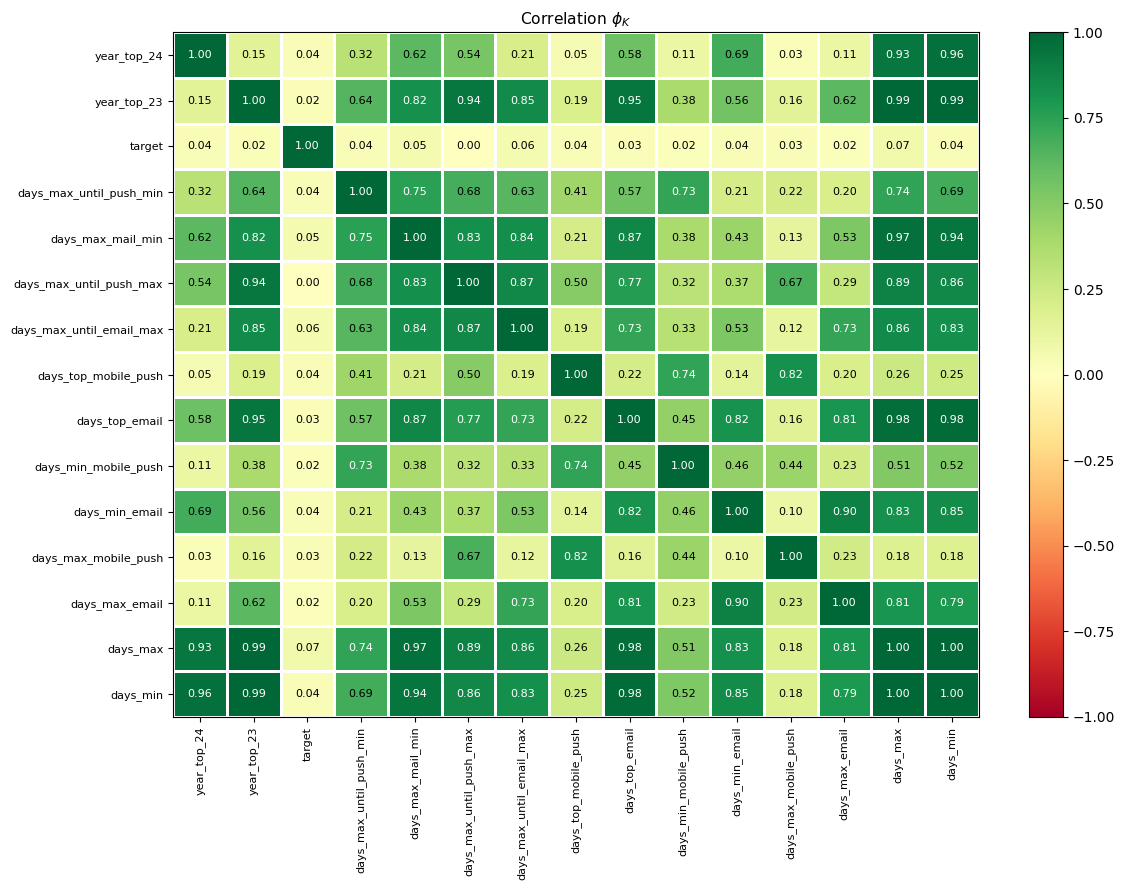

In [256]:
correlation_mtx(
    df.Xy,
    'year_top',
    'days_min',
    'days_max',
    'days_max_email',
    'days_max_mobile_push',
    'days_min_email',
    'days_min_mobile_push',
    'days_top_email',
    'days_top_mobile_push',
    'days_max_until_email_max',
    'days_max_until_push_max',
    'days_max_mail_min',
    'days_max_until_push_min',
    'target',
)


## Model Training


### Data Splitting (Features and Target)

In [257]:
df.X = df.Xy.drop('target', axis=1)
df.y = df.Xy['target']  # override to ensure Xy-mapping after merging by client_id


df.X.shape, *df.y.shape

((23100, 42), 23100)

### Features


In [258]:
numeric_features = [
    'days_max',
    'days_max_email',
    'days_max_mail_min',
    'days_max_mobile_push',
    'days_max_until_email_max',
    'days_max_until_push_max',
    'days_max_until_push_min',
    'days_min',
    'days_min_email',
    'days_min_mobile_push',
    'days_top_email',
    'days_top_mobile_push',
    'message_id_nunique_email',
    'message_id_nunique_mobile_push',
    'price_sum',
    'quantity_sum',
    'bulk_campaign_id_count_email',
    'bulk_campaign_id_count_mobile_push',
]


len(numeric_features)


18

In [259]:
categorical_features = [
    'cat_4e_top',
    'event_rare_email',
    'event_rare_mobile_push',
    'event_top_email',
    'event_top_mobile_push',
]


df.X[categorical_features].nunique().to_frame('number_of_classes').T


,cat_4e_top,event_rare_email,event_rare_mobile_push,event_top_email,event_top_mobile_push
number_of_classes,45,10,6,4,3


In [260]:
df.cache['bc_id_ord'] = [str(x) for x in sorted(list(df.Xy['bc_id_top'].unique()))]


ordinal_features = [
    'bc_id_cat',
    'year_top',
]
ordinal_categories = [
    df.cache['bc_id_ord'],  # bc_id_cat
    ['22', '23', '24'],  # year_top
]


len(df.cache['bc_id_ord']) + 3  # +year


370

### Preprocessor


In [261]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
            ('scaler', MinMaxScaler()),
            ('select', SelectKBest(f_classif, k='all')),
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            (
                'onehot',
                OneHotEncoder(
                    drop='first', sparse_output=False, handle_unknown='ignore'
                )
            ),
            ('select', SelectKBest(score_func=chi2, k='all'))
        ]), categorical_features),
        ('ord', Pipeline(steps=[
            ('encoder', OrdinalEncoder(categories=ordinal_categories)),
        ]), ordinal_features)
    ]
)


if DEV:
    display(preprocessor)


### Pipeline Configuration


In [262]:
pipeline = ImbPipeline(
    steps=[
        ('preprocessor', preprocessor),
        (
            'undersampler',
            RandomUnderSampler(sampling_strategy=MINORITY_SIZE, random_state=df.seed),
        ),
        (
            'clf', 
            CatBoostClassifier(random_seed=df.seed, verbose=0),
        ),
    ]
)


if DEV:
    display(pipeline)


In [263]:
df.cache['cat_mult'] = 10


cbr_distributions = {
    'preprocessor__num__select__k': (
        range(int(len(numeric_features)/4), int(len(numeric_features)))
    ),
    'preprocessor__cat__select__k': (
        range(
            int(len(categorical_features)/4),
            int(len(categorical_features) * df.cache['cat_mult']),
        )
    ),
    'preprocessor__num__scaler': [MinMaxScaler(), StandardScaler()],
    'clf': [CatBoostClassifier(random_seed=df.seed, verbose=False)],
    'clf__iterations': [1_200, 1_400],
    'clf__learning_rate': [0.001, 0.002],
    'clf__l2_leaf_reg': [3.5, 4.0, 4.5],  # default: 3.0
}
lr_distributions = {
    'clf': [LogisticRegression(random_state=df.seed)],
}
rf_distributions = {
    'clf': [RandomForestClassifier(random_state=df.seed)],
}


param_distributions = [cbr_distributions]
if not DEV:
    param_distributions +=[lr_distributions, rf_distributions]


cv_folds = StratifiedKFold(n_splits=int(CV_FOLDS/2), shuffle=True, random_state=df.seed)
cv_folds_x2 = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=df.seed)


cv_folds_x2


StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

### Cross Validation Training


In [264]:
ml = ML()


assert SEARCH_NUM <= 4
for iteration_id in range(SEARCH_NUM):
    bid = '_' + str(iteration_id) if iteration_id != 0 else ''

    # Train Test Split
    # ================
    X_train, df.view['X_test'+bid], y_train, df.view['y_test'+bid] = train_test_split(
        df.X,
        df.y,
        test_size=0.25,
        random_state=df.seed + iteration_id,
        stratify=df.Xy['target'],
    )
    
    # Search Configuration
    # ====================
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=int(max(N_ITER_MIN, N_ITER - (iteration_id * N_ITER_BS_ADAPT_MULT))),
        scoring='roc_auc',
        cv=cv_folds if bool(iteration_id) else cv_folds_x2,
        random_state=df.seed + iteration_id,
        verbose=0,
        n_jobs=-1
    )

    # Train
    # =====
    random_search.fit(X_train, y_train)

    # Store
    # =====
    ml.models.append(random_search.best_estimator_)
    ml.params.append(random_search.best_params_)
    ml.roc_auc.append(round(random_search.best_score_, 4))


roc_auc_val_mean = round(np.mean(ml.roc_auc), 2)


ml.roc_auc, roc_auc_val_mean

/Users/ehoppe/source/github/public/2024/ml_rebuy_prediction/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/ehoppe/source/github/public/2024/ml_rebuy_prediction/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/ehoppe/source/github/public/2024/ml_rebuy_prediction/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/ehoppe/source/github/public/2024/ml_rebuy_prediction/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categor

([0.6794, 0.6648, 0.6356, 0.6732], 0.66)

### Summary (Model Training)

A  pipeline is set up to train the model to predict the customer's purchase probability. Numerical, categorical and ordinal features are processed differently: Numerical features are scaled and selected using `SelectKBest`, while categorical variables are transformed by one-hot encoding and ordinal variables by `OrdinalEncoder`. The final classifier (`RandomForestClassifier`, `LogisticRegression` or `CatBoostClassifier`) is integrated into an `ImbPipeline`, which also contains the sampling strategy (`RandomUnderSampler`) for balancing the classes.

The pipeline is hyperparametrically optimized by `RandomizedSearchCV`, whereby different model types and hyperparameters are tested in order to achieve the highest possible ROC-AUC. Finally, the model performance is evaluated and stored by the `roc_auc` values of the best models.

## Evaluation


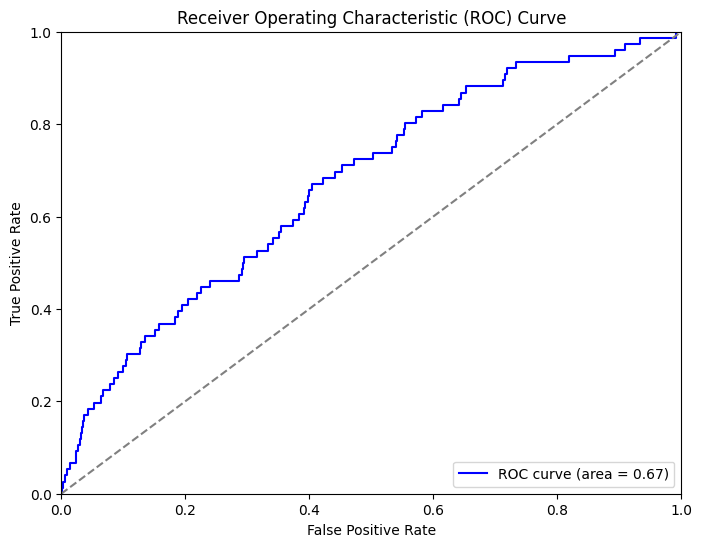

In [265]:
y_pred = ml.models[0].predict_proba(df.view['X_test'])[:, 1]
roc_auc = round(roc_auc_score(df.view['y_test'], y_pred), 4)
fpr, tpr, thresholds = roc_curve(df.view['y_test'], y_pred)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



In [266]:
y_pred_1 = ml.models[1].predict_proba(df.view['X_test_1'])[:, 1]
y_pred_2 = ml.models[2].predict_proba(df.view['X_test_2'])[:, 1]
y_pred_3 = ml.models[3].predict_proba(df.view['X_test_3'])[:, 1]

roc_auc_1 = round(roc_auc_score(df.view['y_test_1'], y_pred_1), 4)
roc_auc_2 = round(roc_auc_score(df.view['y_test_2'], y_pred_2), 4)
roc_auc_3 = round(roc_auc_score(df.view['y_test_3'], y_pred_3), 4)


roc_auc_test = [roc_auc, roc_auc_1, roc_auc_2, roc_auc_3]
roc_auc_test_mean = round(np.mean(roc_auc_test), 2)


roc_auc_val_test_delta = round(abs(roc_auc_val_mean - roc_auc_test_mean), 4)
assert roc_auc_val_test_delta <= 0.03  # +/-


roc_auc_test, roc_auc_test_mean, roc_auc_val_test_delta


([0.6714, 0.6541, 0.6987, 0.6697], 0.67, 0.01)

### Summary (Evaluation)

The model `model_0` is tested for stability by validating the performance over multiple iterations. Four models (including `model_0`) are trained on different train-test splits to evaluate the ROC-AUC metric. Only `model_0` is used in production, while the other models (`model_1`, `model_2`, `model_3`) are only used to calculate the average and deviation of the metrics. The models with `id > 0` are trained with a smaller number of iterations (`N_ITER`) to reduce the computation time. In the end, it is ensured that the deviation between the average of the metrics of `model_0` and the other models (`roc_auc_val_test_delta`) is acceptable and below a defined threshold (e.g. 0.03). This ensures that `model_0` is stable and the results are reliable, even if it does not always provide the best values. The focus is therefore on the consistency and reliability of model performance rather than maximizing individual metrics.


In [267]:
for model_id, ml_param in enumerate(ml.params):
    display(ml_param)
    display(str(ml.roc_auc[model_id]) + ' ' + str(roc_auc_test[model_id]))

{'preprocessor__num__select__k': 15,
 'preprocessor__num__scaler': StandardScaler(),
 'preprocessor__cat__select__k': 38,
 'clf__learning_rate': 0.002,
 'clf__l2_leaf_reg': 3.5,
 'clf__iterations': 1200,
 'clf': <catboost.core.CatBoostClassifier at 0x3b9fec190>}

'0.6794 0.6714'

{'preprocessor__num__select__k': 5,
 'preprocessor__num__scaler': StandardScaler(),
 'preprocessor__cat__select__k': 43,
 'clf__learning_rate': 0.002,
 'clf__l2_leaf_reg': 4.0,
 'clf__iterations': 1200,
 'clf': <catboost.core.CatBoostClassifier at 0x3b9fec190>}

'0.6648 0.6541'

{'preprocessor__num__select__k': 6,
 'preprocessor__num__scaler': StandardScaler(),
 'preprocessor__cat__select__k': 14,
 'clf__learning_rate': 0.001,
 'clf__l2_leaf_reg': 4.5,
 'clf__iterations': 1400,
 'clf': <catboost.core.CatBoostClassifier at 0x3b9fec190>}

'0.6356 0.6987'

{'preprocessor__num__select__k': 12,
 'preprocessor__num__scaler': MinMaxScaler(),
 'preprocessor__cat__select__k': 35,
 'clf__learning_rate': 0.001,
 'clf__l2_leaf_reg': 4.0,
 'clf__iterations': 1200,
 'clf': <catboost.core.CatBoostClassifier at 0x3b9fec190>}

'0.6732 0.6697'

### Manual Hyperparameter Monitoring

This cell displays the parameters and the corresponding ROC-AUC metrics for the different models (`model_0`, `model_1`, `model_2`, `model_3`). Here, **`model_0`** is the main model whose parameters and metrics are decisive for production. The other models are used to monitor the **stability of parameters** and **performance deviations**. The results can be used to check how much the parameters found vary between iterations to identify potential areas for improvement. For example, if a particular learning parameter (e.g. `learning_rate`) is never chosen as optimal, this indicates that this parameter may be redundant and could be removed from the pipeline. This process dynamically improves the **hyperparameter optimization** as `RandomizedSearch` gets more chances with a more efficient parameter search. The other models thus help to further refine the **Pipeline**, while `model_0` remains the final model for production.


### Result (ROC-AUC)


In [268]:
display(
    'Validation: ' + str(ml.roc_auc[model_id]),
    'Test: ' + str(roc_auc_test[model_id])
)

ml.params[0]

'Validation: 0.6732'

'Test: 0.6697'

{'preprocessor__num__select__k': 15,
 'preprocessor__num__scaler': StandardScaler(),
 'preprocessor__cat__select__k': 38,
 'clf__learning_rate': 0.002,
 'clf__l2_leaf_reg': 3.5,
 'clf__iterations': 1200,
 'clf': <catboost.core.CatBoostClassifier at 0x3b9fec190>}

## Feature Importances


In [269]:
best_model = ml.models[0]
catboost_model = best_model.named_steps['clf']
importances = catboost_model.get_feature_importance()
X_transformed = best_model.named_steps['preprocessor'].transform(X_train)
num_features_selected = (
    best_model.named_steps['preprocessor']
    .named_transformers_['num']
    .named_steps['select'].get_support()
)
num_features_names_selected = np.array(numeric_features)[num_features_selected]
cat_features_names = (
    best_model.named_steps['preprocessor'].named_transformers_['cat']
    .named_steps['onehot'].get_feature_names_out(categorical_features)
)
cat_features_selected = (
    best_model.named_steps['preprocessor']
    .named_transformers_['cat'].named_steps['select'].get_support()
)
cat_features_names_selected = np.array(cat_features_names)[cat_features_selected]
ord_features_names = ordinal_features
all_feature_names_cleaned = list(num_features_names_selected)
all_feature_names_cleaned += list(cat_features_names_selected)
all_feature_names_cleaned += list(ord_features_names)


all_feature_names_cleaned

['days_max',
 'days_max_email',
 'days_max_mail_min',
 'days_max_mobile_push',
 'days_max_until_email_max',
 'days_max_until_push_min',
 'days_min',
 'days_min_email',
 'days_top_email',
 'days_top_mobile_push',
 'message_id_nunique_email',
 'message_id_nunique_mobile_push',
 'price_sum',
 'quantity_sum',
 'bulk_campaign_id_count_mobile_push',
 'cat_4e_top_123',
 'cat_4e_top_124',
 'cat_4e_top_142',
 'cat_4e_top_146',
 'cat_4e_top_155',
 'cat_4e_top_181',
 'cat_4e_top_1828',
 'cat_4e_top_239',
 'cat_4e_top_258',
 'cat_4e_top_260',
 'cat_4e_top_267',
 'cat_4e_top_274',
 'cat_4e_top_275',
 'cat_4e_top_290',
 'cat_4e_top_326',
 'cat_4e_top_329',
 'cat_4e_top_340',
 'cat_4e_top_341',
 'cat_4e_top_344',
 'cat_4e_top_5548',
 'cat_4e_top_5669',
 'cat_4e_top_57',
 'cat_4e_top_6065',
 'cat_4e_top_61',
 'cat_4e_top_62',
 'event_rare_email_complain',
 'event_rare_email_hard_bounce',
 'event_rare_email_hbq_spam',
 'event_rare_email_open',
 'event_rare_email_purchase',
 'event_rare_email_soft_bounc

In [270]:
if len(importances) == len(all_feature_names_cleaned):
    feature_importances = pd.DataFrame({
        'Feature': all_feature_names_cleaned,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
else:
    print('Error: The number of adjusted feature names and importances does not match')

In [271]:
non_numerical_features = list(cat_features_names_selected) + ord_features_names
numerical_importances = (
    feature_importances[
        feature_importances['Feature'].isin(num_features_names_selected)
    ]
)
categorical_importances = (
    feature_importances[feature_importances['Feature'].isin(non_numerical_features)]
)

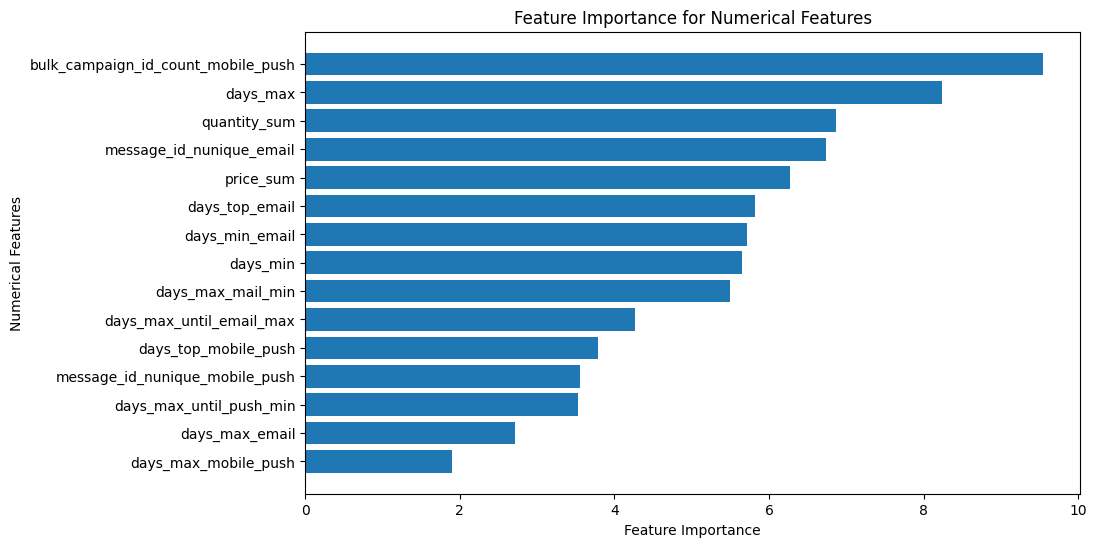

In [272]:
plt.figure(figsize=(10, 6))
plt.barh(numerical_importances['Feature'], numerical_importances['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Numerical Features')
plt.title('Feature Importance for Numerical Features')
plt.gca().invert_yaxis()


plt.show()


The graph shows the **feature importance** of the numerical features for the model, where the top three features are the most important features that contribute to the prediction of purchase probability in the model. The **three most important features** in this graph are:

1. **`days_max`**: This feature is the most significant in the model, indicating that the maximum number of days that may have passed between two relevant events (e.g. since the last purchase or interaction) plays an important role in predicting a customer's future purchase likelihood.
  
2. **`bulk_campaign_id_count_mobile_push`**: This feature refers to the number of campaigns sent to the customer via mobile push notifications. Its high importance shows that customers who have been targeted more frequently via mobile push campaigns are likely to exhibit a certain behavior that is crucial for predicting purchase likelihood.
  
3. **`quantity_sum`**: The total number of products purchased is the third most important feature. This indicates that past purchase behavior in terms of the quantity of items purchased is a good indicator of a customer's future purchase behavior.

These three features give the model important insights into customer behavior and interaction with marketing campaigns, which significantly improves prediction accuracy.


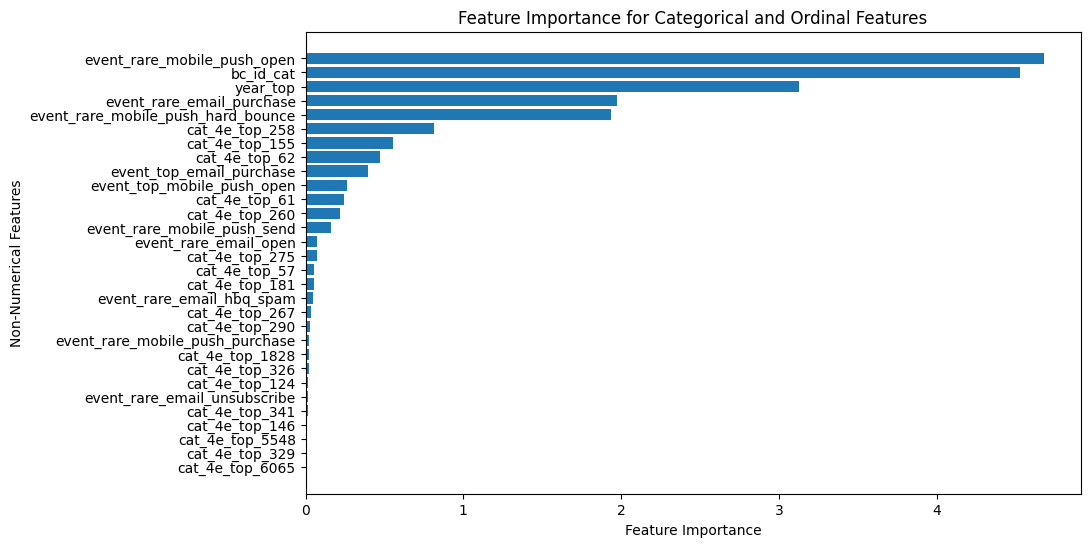

In [273]:
plt.figure(figsize=(10, 6))
plt.barh(
    categorical_importances[:FI_LIMIT]['Feature'],
    categorical_importances[:FI_LIMIT]['Importance'],
)
plt.xlabel('Feature Importance')
plt.ylabel('Non-Numerical Features')
plt.title('Feature Importance for Categorical and Ordinal Features')
plt.gca().invert_yaxis()


plt.show()


The chart shows the **feature importance for categorical and ordinal features**, identifying the most important features for predicting the likelihood of purchase in the model. The **three most important features** in this graph are:

1. **`event_rare_mobile_push_open`**: This feature is the most significant among the categorical and ordinal variables. It describes whether rare push notifications sent to the customer were opened. The model recognizes this as a strong indicator of purchase likelihood, as customers who respond to infrequent messages may show a higher level of interest.

2. **`bc_id_cat`**: This feature represents a categorical variable that describes specific campaign IDs. The high Feature Importance indicates that certain campaigns are particularly successful, which can strongly influence behavior and the likelihood of a purchase.

3. **`year_top`**: The third most important feature is `year_top`, which probably represents the year in which the activities under consideration took place. This could give an indication of temporal trends, with the model recognizing that the year of the campaign or purchase has a large influence on the likelihood of a repeat purchase.

These three features contribute significantly to the explanation of customer behavior and predictive accuracy by incorporating specific events and their temporal or campaign-related influences on purchase behavior.


## Conclusion


In this project, a machine learning model was developed to predict the likelihood of customers making a purchase within the next 90 days. The focus was on creating a robust pipeline that integrates both data processing and model training steps to effectively utilize customer interactions and purchase history. The numerical, categorical and ordinal features were treated with specific transformation methods to ensure that the model received the most relevant information for prediction.

The training process involved multiple iterations to ensure the stability and reliability of the model performance. The decision to use only the model of the first iteration (`model_0`) for production and to use the other iterations to evaluate the average stability of the ROC-AUC resulted in a pragmatic and production-oriented solution. This allowed for an efficient hedge against random fluctuations while ensuring that the model can provide consistent predictions in different scenarios.

The evaluation of feature importance showed that both numerical features such as the maximum number of days since a last relevant event and categorical features such as the opening of infrequent push notifications had significant influences on the probability of purchase. These findings provide valuable insights into customer behavior and support marketing in efficiently designing targeted campaigns.

Overall, the developed model is not only powerful but also stable, as it is able to deliver repeatable and consistent results. The iterative approach of continuously improving the model parameters and gradually eliminating unnecessary parameters ensures dynamic and adaptive optimization. The model thus provides a reliable basis for developing targeted marketing strategies and promoting customer loyalty through a personalized approach.